In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("dataset_hosp_vacc.csv", parse_dates=["Date"])
test = pd.read_csv("dataset_hosp_vacc_test.csv", parse_dates=["Date"])

# "D:\tailwyndz\dataset_hosp_vacc_test.csv"
# sample_sub = pd.read_csv('demand_forecasting_datasets/sample_submission.csv')
df = pd.read_csv("dataset_hosp_vacc.csv", parse_dates=["Date"])

df.head(5)

date_column = "Date" 
target_column= "new_hospitalized_patients"
feature_column_1 = "location_key"
feature_column_2 = "new_persons_vaccinated"


# #load dataset
# train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
# test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
# df = pd.concat([train, test], sort=False) # veri önişleme için test ve train bir araya getirdim
# df.head()

In [3]:
df.columns


Index(['Unnamed: 0', 'Date', 'location_key', 'new_hospitalized_patients', 'cumulative_hospitalized_patients', 'current_hospitalized_patients', 'new_intensive_care_patients', 'cumulative_intensive_care_patients', 'current_intensive_care_patients', 'current_ventilator_patients', 'new_persons_vaccinated', 'cumulative_persons_vaccinated', 'new_persons_fully_vaccinated', 'cumulative_persons_fully_vaccinated', 'new_vaccine_doses_administered', 'cumulative_vaccine_doses_administered'], dtype='object')

In [4]:
df.drop(['cumulative_hospitalized_patients','new_intensive_care_patients','cumulative_intensive_care_patients'], axis=1, inplace=True)

In [5]:
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)


In [6]:
df.head(5)

,Date,location_key,new_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,current_ventilator_patients,new_persons_vaccinated,cumulative_persons_vaccinated,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,new_vaccine_doses_administered,cumulative_vaccine_doses_administered
0,2020-02-12,AU,0,0,0,0,0,0,0,0,0,0
1,2020-02-13,AU,0,0,0,0,0,0,0,0,0,0
2,2020-02-20,AU,0,0,0,0,0,0,0,0,0,0
3,2020-02-26,BR,1,0,0,0,0,0,0,0,0,0
4,2020-02-28,AU,0,0,0,0,0,0,0,0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182816 entries, 0 to 182815
Data columns (total 12 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   Date                                   182816 non-null  datetime64[ns]
 1   location_key                           182816 non-null  object        
 2   new_hospitalized_patients              182816 non-null  int64         
 3   current_hospitalized_patients          182816 non-null  int64         
 4   current_intensive_care_patients        182816 non-null  int64         
 5   current_ventilator_patients            182816 non-null  int64         
 6   new_persons_vaccinated                 182816 non-null  int64         
 7   cumulative_persons_vaccinated          182816 non-null  int64         
 8   new_persons_fully_vaccinated           182816 non-null  int64         
 9   cumulative_persons_fully_vaccinated    182816 no

In [8]:
# df= df.set_index('Date')

In [9]:
df.dtypes


Date                                     datetime64[ns]
location_key                                     object
new_hospitalized_patients                         int64
current_hospitalized_patients                     int64
current_intensive_care_patients                   int64
current_ventilator_patients                       int64
new_persons_vaccinated                            int64
cumulative_persons_vaccinated                     int64
new_persons_fully_vaccinated                      int64
cumulative_persons_fully_vaccinated               int64
new_vaccine_doses_administered                    int64
cumulative_vaccine_doses_administered             int64
dtype: object

In [10]:
print("Train set:",train.shape)
print("Test set:",test.shape)

Train set: (182816, 16)
Test set: (13632, 8)


In [11]:
# combining the training and test dataset
# df = train +test

df.shape

(182816, 12)

In [12]:
# using quantile function -transform a numeric input variable to have a different data distribution


df.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

,0.00,0.05,0.25,0.50,0.75,0.95,0.99,1.00
new_hospitalized_patients,0.0,0.0,0.0,0.0,3.00,55.00,400.00,11246.0
current_hospitalized_patients,0.0,0.0,0.0,0.0,0.00,0.00,78.85,5390.0
current_intensive_care_patients,0.0,0.0,0.0,0.0,0.00,0.00,11.00,947.0
current_ventilator_patients,0.0,0.0,0.0,0.0,0.00,0.00,3.00,557.0
new_persons_vaccinated,-350160.0,0.0,1.0,8.0,47.00,3250.00,46710.25,2118821.0
cumulative_persons_vaccinated,0.0,1.0,561.0,2341.0,10558.00,999810.75,8776278.20,174333400.0
new_persons_fully_vaccinated,-233678.0,0.0,0.0,4.0,35.00,1931.00,36585.65,1600527.0
cumulative_persons_fully_vaccinated,0.0,0.0,163.0,1064.0,5427.00,425638.75,6477633.35,152340188.0
new_vaccine_doses_administered,-296286.0,0.0,4.0,21.0,99.00,6827.00,86546.05,2979630.0
cumulative_vaccine_doses_administered,0.0,3.0,786.0,3604.5,16469.25,1385242.00,15924807.60,326673588.0


In [13]:
df[date_column].min()

Timestamp('2020-01-25 00:00:00')

In [14]:
df[date_column].max()

Timestamp('2022-03-13 00:00:00')

In [15]:
# 25% - The 25% percentile*.
# 50% - The 50% percentile*.
# 75% - The 75% percentile*.
# max - the maximum value.

# *Percentile meaning: how many of the values are less than the given percentile. Read more about percentiles in our Machine Learning Percentile chapter.

df[target_column].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])
# df["sales"].describe()

count    182816.000000
mean         23.715999
std         226.523171
min           0.000000
10%           0.000000
30%           0.000000
50%           0.000000
70%           2.000000
80%           4.000000
90%          15.000000
95%          55.000000
99%         400.000000
max       11246.000000
Name: new_hospitalized_patients, dtype: float64

In [16]:
# to find the number of unique values inthe column

df[feature_column_1].nunique()

580

In [90]:

# df[feature_column_2].nunique() 

In [91]:
# grouping the store column and finding the count of unique items in each store


# df.groupby([feature_column_1])[feature_column_2].nunique()

# df.groupby([feature_column_1])[target_column].nunique()

In [17]:
# group by 2 coumns and finding sales sum and other parameters like mean median and mode

df.groupby([feature_column_1]).agg({target_column: ["sum", "mean", "median", "std"],feature_column_2: ["sum","mean", "median", "std"]})

new_hospitalized_patients                                new_persons_vaccinated                                     
                                   sum        mean median         std                    sum          mean   median           std
location_key                                                                                                                     
AR                              232643  537.281755  494.0  285.035539                6630670  15313.325635  10093.0  14020.371561
AR_A                              8491   21.940568   18.0   13.273101                 122170    315.684755    217.0    383.611072
AR_A_007                           253    0.773700    0.0    1.152822                   8003     24.474006     15.0     29.286899
AR_A_014                            73    0.270370    0.0    0.607460                   1141      4.225926      2.0      6.830181
AR_A_021                            64    0.226950    0.0    0.538468                   1399      4.960993      3.0      6.459998
...                                ...         ...    ...         ...                    ...           ...      ...           ...
BR_RR                             4662    7.459200    5.0    8.123960                 372961    596.737600      0.0   1474.739109
BR_RS                           113073  158.587658   99.0  184.288683                9271206  13003.093969      0.0  22824.600513
BR_SC                            74842  104.967742   71.0  106.901024                6032408   8460.600281      0.0  19685.755363
BR_SE                            17663   27.049005   19.0   26.827283                1803078   2761.222052      0.0   5372.325502
BR_SP                           526350  714.179104  540.0  678.697006               41590606  56432.301221   7525.0  99238.417792

[580 rows x 8 columns]

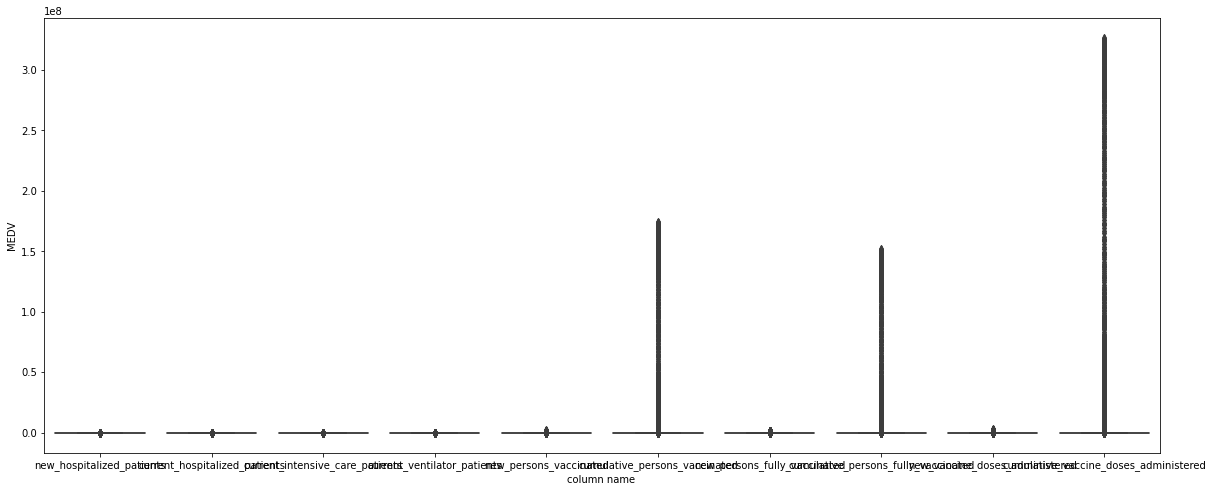

In [18]:
import seaborn as sns
import matplotlib.pyplot as ply
fig, ax = plt.subplots(figsize=(20,8))
# ax = sns.boxplot(x="variable", y="value", data=pd.melt(df.loc[ : , df.columns != ('Date')].astype('float')))
# ax = sns.boxplot(x="variable", y="value", data=pd.melt(df))
sns.boxplot(data=df)
ax.set_xlabel('column name ')
ax.set_ylabel('MEDV')
plt.show()

In [19]:
df['month'] = df.Date.dt.month

df['day_of_month'] = df.Date.dt.day

df['day_of_year'] = df.Date.dt.dayofyear 

df['week_of_year'] = df.Date.dt.weekofyear

df['day_of_week'] = df.Date.dt.dayofweek

df['year'] = df.Date.dt.year

df["is_wknd"] = df.Date.dt.weekday // 4

df['is_month_start'] = df.Date.dt.is_month_start.astype(int)

df['is_month_end'] = df.Date.dt.is_month_end.astype(int) 

In [20]:
df.head()

,Date,location_key,new_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,current_ventilator_patients,new_persons_vaccinated,cumulative_persons_vaccinated,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,new_vaccine_doses_administered,cumulative_vaccine_doses_administered,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2020-02-12,AU,0,0,0,0,0,0,0,0,0,0,2,12,43,7,2,2020,0,0,0
1,2020-02-13,AU,0,0,0,0,0,0,0,0,0,0,2,13,44,7,3,2020,0,0,0
2,2020-02-20,AU,0,0,0,0,0,0,0,0,0,0,2,20,51,8,3,2020,0,0,0
3,2020-02-26,BR,1,0,0,0,0,0,0,0,0,0,2,26,57,9,2,2020,0,0,0
4,2020-02-28,AU,0,0,0,0,0,0,0,0,0,0,2,28,59,9,4,2020,1,0,0


In [21]:
# month wise forecast

df.groupby([feature_column_1, "month"]).agg({target_column: ["sum", "mean", "median", "std"]})

new_hospitalized_patients                                 
                                         sum         mean  median         std
location_key month                                                           
AR           1                         36036   581.225806   574.5  113.777957
             2                         19841   367.425926   386.5  111.581699
             3                         16801   430.794872   477.0  139.916362
             4                         25348   844.933333   854.5  153.187497
             5                         32381  1044.548387  1045.0  161.952017
...                                      ...          ...     ...         ...
BR_SP        8                         34736   560.258065   523.0  232.440998
             9                         23871   397.850000   336.5  184.935520
             10                        16269   262.403226   212.0  149.040259
             11                        17357   289.283333   156.5  259.974972
             12                        21812   351.806452    91.5  383.679419

[6924 rows x 4 columns]

In [22]:
# random noise function 

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [23]:

# sorting according to date

df.sort_values(by=[feature_column_1, 'Date'], axis=0, inplace=True)
df.head()

,Date,location_key,new_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,current_ventilator_patients,new_persons_vaccinated,cumulative_persons_vaccinated,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,new_vaccine_doses_administered,cumulative_vaccine_doses_administered,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
957,2020-12-29,AR,594,0,0,0,2862,2862,0,0,2862,2862,12,29,364,53,1,2020,0,0,0
156451,2020-12-30,AR,553,0,0,0,2760,5622,0,0,2760,5622,12,30,365,53,2,2020,0,0,0
1032,2020-12-31,AR,403,0,0,0,378,6000,0,0,378,6000,12,31,366,53,3,2020,0,0,1
156511,2021-01-01,AR,450,0,0,0,15,6015,0,0,15,6015,1,1,1,53,4,2021,1,1,0
45943,2021-01-02,AR,575,0,0,0,410,6425,0,0,410,6425,1,2,2,53,5,2021,1,0,0


In [24]:
# lag features function 


def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby([feature_column_1])[target_column].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [25]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby([feature_column_1])[target_column]. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546, 730])

In [26]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby([feature_column_1])[target_column].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
df.tail()

,Date,location_key,new_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,current_ventilator_patients,new_persons_vaccinated,cumulative_persons_vaccinated,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,new_vaccine_doses_administered,cumulative_vaccine_doses_administered,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,sales_ewm_alpha_099_lag_91,sales_ewm_alpha_099_lag_98,sales_ewm_alpha_099_lag_105,sales_ewm_alpha_099_lag_112,sales_ewm_alpha_099_lag_180,sales_ewm_alpha_099_lag_270,sales_ewm_alpha_099_lag_365,sales_ewm_alpha_099_lag_546,sales_ewm_alpha_099_lag_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
66650,2022-03-06,BR_SP,1,0,0,0,1548,41497300,5171,37198855,6719,78696155,3,6,65,9,6,2022,1,0,0,42.488838,50.496416,48.614973,41.523715,65.683389,60.756859,179.631628,1175.734302,327.644786,-0.054776,630.953436,1025.415487,961.845838,42.261289,52.191507,48.450609,42.561871,328.381372,2533.318330,1816.123669,329.968307,0.990099,43.331299,52.988344,50.266308,44.844007,321.951368,2543.764728,1812.889164,341.809104,0.952381,44.721753,54.056568,52.571451,47.763170,314.089686,2550.519790,1809.443278,356.550249,0.909099,47.673606,56.450116,57.335882,53.762821,299.412984,2543.695874,1804.340861,386.001814,0.833547,50.863930,59.207117,62.327478,59.893433,286.877443,2511.621869,1800.536485,415.867381,0.770542,57.943324,65.745493,72.423067,72.152638,271.093097,2385.447494,1782.285535,478.769082,0.677419
133378,2022-03-07,BR_SP,3,0,0,0,22863,41520163,84149,37283004,107012,78803167,3,7,66,10,0,2022,0,0,0,26.110914,41.713839,58.325570,39.326224,43.684001,62.114870,167.761861,1168.850092,321.925328,3.238626,623.917334,1022.925210,963.211317,26.162613,41.111915,56.914506,38.045619,198.313814,2395.393183,1183.391237,322.079683,0.009901,26.866565,41.599417,56.663315,38.342200,203.247568,2401.488236,1208.794458,322.990455,0.047619,27.872175,42.305657,56.557145,38.976317,208.708969,2409.651979,1240.244328,325.455025,0.090909,30.334721,44.090023,57.067176,41.152564,217.482597,2423.939175,1302.468172,334.800363,0.166667,33.459179,46.462135,58.598243,44.568030,223.963233,2429.286561,1364.060946,350.160214,0.230769,41.971662,53.372746,64.711534,55.076319,234.046549,2389.723747,1479.642767,400.384541,0.333333
111219,2022-03-08,BR_SP,2,0,0,0,22884,41543047,76746,37359750,99630,78902797,3,8,67,10,1,2022,0,0,0,81.197149,99.986487,109.559457,46.110635,132.191509,124.628487,330.362641,2514.677148,368.894655,1.211140,614.997810,1020.409358,963.785502,82.431626,98.421119,108.479145,47.900456,433.623138,2283.133932,1170

In [27]:


df = pd.get_dummies(df, columns=['day_of_week', 'month'])

In [28]:
# [feature_column_1, feature_column_2])[target_column

# df[feature_column_1] = np.log1p(df[feature_column_1].values)

In [29]:
from sklearn import preprocessing

# fit_transform(y)
df[feature_column_1] = preprocessing.LabelEncoder().fit_transform(df[feature_column_1].values)

# le = preprocessing.LabelEncoder()
# >>> le.fit(["paris", "paris", "tokyo", "amsterdam"])

In [30]:
# df['location_key'] = pd.factorize(df['location_key'])[0] 
# 

In [31]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [32]:

train = df.loc[(df[date_column] < "2022-01-01"), :]


val = df.loc[(df[date_column] >= "2020-01-25") & (df[date_column] < "2022-04-01"), :]


cols = [col for col in train.columns if col not in [date_column, 'id', target_column, "year"]]

In [33]:

Y_train = train[target_column]


X_train = train[cols]


Y_val = val[target_column]


X_val = val[cols] 


Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


((169184,), (169184, 102), (182816,), (182816, 102))

In [34]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [35]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [36]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, 
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)


smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 14.4875	training's SMAPE: nan	valid_1's l1: 17.7861	valid_1's SMAPE: nan
[200]	training's l1: 9.89529	training's SMAPE: nan	valid_1's l1: 13.5632	valid_1's SMAPE: nan
Early stopping, best iteration is:
[1]	training's l1: 42.2051	training's SMAPE: nan	valid_1's l1: 41.0795	valid_1's SMAPE: nan


198.0397259472404

In [37]:
df.dtypes

Date                               datetime64[ns]
location_key                                int32
new_hospitalized_patients                   int64
current_hospitalized_patients               int64
current_intensive_care_patients             int64
                                        ...      
month_8                                     uint8
month_9                                     uint8
month_10                                    uint8
month_11                                    uint8
month_12                                    uint8
Length: 105, dtype: object

In [41]:
#Final Model



train = df.loc[~df.new_hospitalized_patients.isna()]
Y_train = train[target_column]
X_train = train[cols]

test = df.loc[df.new_hospitalized_patients.isna()]
X_test = test[cols]

In [47]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": 198}

# LightGBM dataset

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062467 seconds.
You can set `force_col_wise=true` to remove the overhead.


ValueError: Input data must be 2 dimensional and non empty.

In [44]:
# [feature_column_1, feature_column_2])[target_column

forecast = pd.DataFrame({date_column:test[date_column],
                        feature_column_1:test['location_key'],
                        feature_column_2:test['new_persons_vaccinated'],
                        target_column:test_preds
                        })

forecast[(forecast.location_key ==529 ) ].set_index(date_column).new_hospitalized_patients.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Store 1 Item 1 Forecast");

NameError: name 'test_preds' is not defined

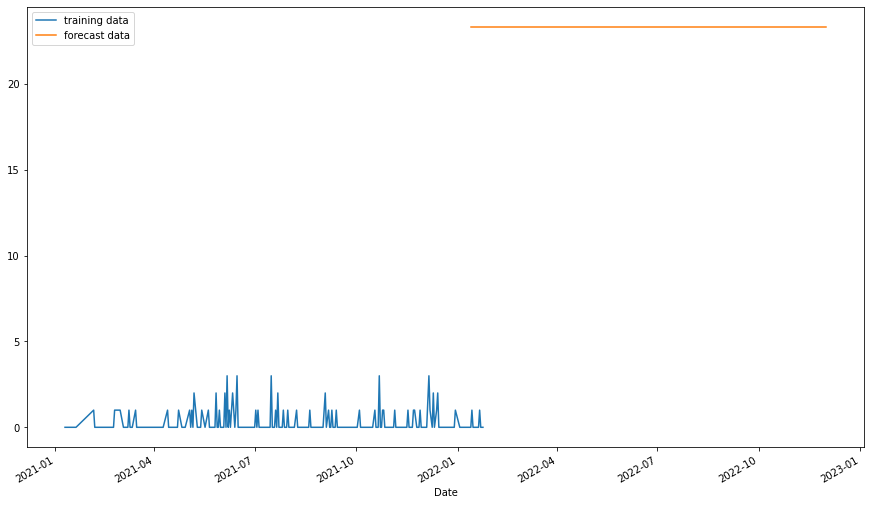

In [53]:


train[(train.location_key == 3)].set_index(date_column).new_hospitalized_patients.plot(figsize = (15,9),legend=True, label = "training data")
forecast[(forecast.location_key == 3)].set_index(date_column).new_hospitalized_patients.plot(legend=True, label = "forecast data");

In [47]:
df.shape

(196448, 109)

In [50]:
# forecast[target_column] = preprocessing.LabelEncoder().inverse_transform(forecast[target_column].values) 

In [51]:
forecast

,Date,location_key,new_persons_vaccinated,new_hospitalized_patients
20,2022-01-01,0,60,23.331145
12692,2022-01-02,0,43568,23.331145
13413,2022-01-03,0,5989,23.331145
6011,2022-01-13,0,7600,23.331145
6717,2022-01-14,0,6292,23.331145
...,...,...,...,...
5101,2022-11-01,579,9833,23.331145
12994,2022-11-02,579,68292,23.331145
13609,2022-11-03,579,26126,23.331145
5371,2022-12-01,579,10405,23.331145


In [87]:
forecast[feature_column_1].nunique()

579

In [86]:
forecast[(forecast.location_key == 4)]

,Date,location_key,new_persons_vaccinated,new_hospitalized_patients
6232,2022-01-13,4,1,23.331145
6447,2022-01-14,4,1,23.331145
7570,2022-01-16,4,0,23.331145
7996,2022-01-17,4,3,23.331145
8813,2022-01-18,4,0,23.331145
9161,2022-01-19,4,1,23.331145
10063,2022-01-20,4,2,23.331145
10148,2022-01-21,4,2,23.331145
11550,2022-01-24,4,0,23.331145
12167,2022-01-25,4,1,23.331145
